In [1]:
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import random
import os
import numpy as np
import torch
import sys

In [2]:
sys.path.append('../utils')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True


SEED = 42
seed_everything(SEED)

In [5]:
from training_nn import training
from evaluation import evaluate_model, plot_loss
from process_data import get_desc
from models import CNN, RNN
from dataset import Onehot, Phys

Load RBD mutation sequences interacted with four antibodies

In [12]:
whole_train = pd.read_csv("../dataset/whole_train.csv")
whole_test = pd.read_csv("../dataset/whole_test.csv")

In [13]:
whole_train.head()

,junction_aa,consensus_count,Label,Distance,Antibody
0,KNAGFNCYNPLETYGFWRTGGVDW,1,1,9,ACE2
1,KNEQFNCYGPINAYGFQRTGGEDW,1,0,10,ACE2
2,KNQKFNCYVPLFHYGFWPTVGVGF,1,1,8,ACE2
3,KNQGFNCYNPLVNYGFYRTNGRSF,1,1,9,ACE2
4,KNRGFNCYKPLPGYGFQRTDGINW,2,0,9,ACE2


Select RBD sequences to train, validation, test data interacted with antibody of interest

In [14]:
def data_split(train, test, target_ab='LY555'):
    target_data = train[train['Antibody'] == target_ab]
    train = target_data.sample(frac=0.7, random_state=SEED)
    valid = target_data.drop(train.index)
    test = test[test['Antibody'] == target_ab]
    return train, valid, test


In [15]:
train_data, valid_data, test_data = data_split(whole_train, whole_test)

Prepare dataloaders for train, valid and test data

In [16]:
def prepare_dataloader(df, dataset_torch, batch_size=5, shuffle=True):
    dataset = dataset_torch(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader

In [17]:
trainloader = prepare_dataloader(train_data, Onehot, batch_size=5, shuffle=True)
validloader = prepare_dataloader(valid_data, Onehot, batch_size=5, shuffle=True)
testloader = prepare_dataloader(test_data, Onehot, batch_size=5, shuffle=True)

CNN model training

In [12]:
model = CNN(20, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 16
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 16/16 [01:31<00:00,  5.70s/it]


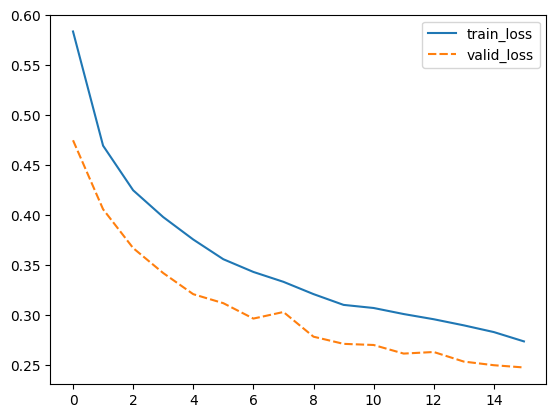

In [13]:
plot_loss(loss_train_hist, loss_valid_hist)

LY555 Escape prediction: classification metrics using RBD mutant sequences one-hot encoded - CNN trained model on full data

In [14]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.900417,0.841608,0.955705,0.895035,0.958103


RNN model training

In [78]:
model = RNN(20, 24, 70, 2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 15
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 15/15 [01:24<00:00,  5.62s/it]


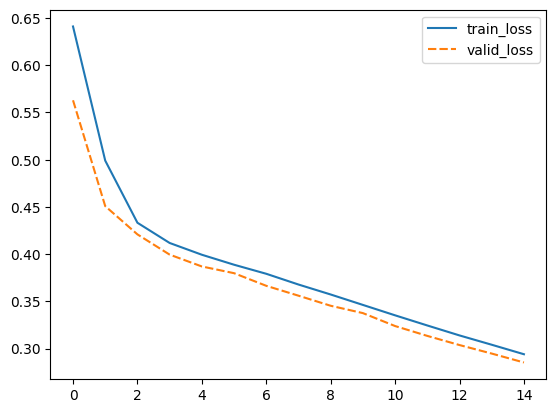

In [79]:
plot_loss(loss_train_hist, loss_valid_hist)

LY555 Escape prediction: classification metrics using RBD mutant sequences one-hot encoded - RNN trained model on full data

In [80]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.876565,0.809693,0.937073,0.868738,0.944608


Read dataset with physical features

In [ ]:
train_path = '../dataset/phys_train.csv'
test_path = '../dataset/phys_test.csv'

In [69]:
whole_train = pd.read_csv(train_path)
whole_test = pd.read_csv(test_path)

Convert str to float datatype of features

In [70]:
whole_train['repr'] = get_desc(whole_train)
whole_test['repr'] = get_desc(whole_test)

In [71]:
train_data, valid_data, test_data = data_split(whole_train, whole_test)

In [76]:
trainloader = prepare_dataloader(train_data, Phys, batch_size=5, shuffle=True)
validloader = prepare_dataloader(valid_data, Phys, batch_size=5, shuffle=True)
testloader = prepare_dataloader(test_data, Phys, batch_size=5, shuffle=True)

CNN model training

In [77]:
model = CNN(40, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 16
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 16/16 [05:11<00:00, 19.47s/it]


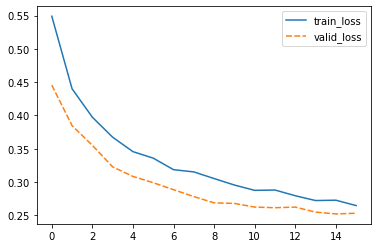

In [78]:
plot_loss(loss_train_hist, loss_valid_hist)

LY555 Escape prediction: classification metrics using RBD mutant sequences (physical features encoded) - CNN trained model on full data

In [79]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.902206,0.847518,0.953457,0.897372,0.959425


RNN model training

In [80]:
model = RNN(40, 24, 70, 2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 15
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 15/15 [10:25<00:00, 41.70s/it]


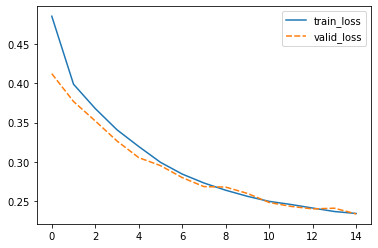

In [81]:
plot_loss(loss_train_hist, loss_valid_hist)

LY555 Escape prediction: classification metrics using RBD mutant sequences (physical features encoded) - RNN trained model on full data

In [82]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.905188,0.868794,0.938697,0.902394,0.957798
